In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from src.GP.data import *
from src.GP.plotting import *
from src.GP.GP import *
from src.GP.utils import *

import scienceplots

plt.style.use('science')

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import yaml

In [3]:
results_path = "/Users/jake/Python/Obs_and_exp_data/results/simulated_plot_exp/09-24-17:33:55/results.metrics"

In [4]:
with open(results_path, "r") as f:
    results_dict = yaml.safe_load(f) 

df = pd.DataFrame()
for model_name in results_dict:
    model_df = pd.DataFrame(results_dict[model_name])
    model_df["model"] = model_name
    df = pd.concat([df,model_df])
df.groupby(['model']).agg(['mean', 'std'])

COVERAGE_ID           COVERAGE_OD           Interval_width_ID  \
                    mean       std        mean       std              mean   
model                                                                        
fixed_MTGP      0.922161  0.109804    0.792042  0.233148          0.508948   
standard_GP     0.991107  0.033147    0.808746  0.234907          3.877725   
trained_MTGP    0.579357  0.379697    0.579043  0.363663          0.300671   

                       Interval_width_OD              MSE_ID            \
                   std              mean       std      mean       std   
model                                                                    
fixed_MTGP    0.068890          2.737991  0.573815  0.021211  0.013705   
standard_GP   0.295192          3.917817  0.016336  0.487032  0.415474   
trained_MTGP  0.189117          2.557834  1.534157  0.028465  0.024174   

                MSE_OD            
                  mean       std  
model                             
fixed_MTGP    1.651568  1.721634  
standard_GP   2.573203  2.712396  
trained_MTGP  2.352938  3.400822

In [5]:
fixed_MTGP_df = pd.DataFrame(results_dict["fixed_MTGP"])
trained_MTGP_df = pd.DataFrame(results_dict["trained_MTGP"])

In [6]:
fixed_MTGP_df.agg(['mean', 'std'])

,COVERAGE_ID,COVERAGE_OD,Interval_width_ID,Interval_width_OD,MSE_ID,MSE_OD
mean,0.922161,0.792042,0.508948,2.737991,0.021211,1.651568
std,0.109804,0.233148,0.068890,0.573815,0.013705,1.721634


In [7]:
trained_MTGP_df.agg(['mean', 'std'])

,COVERAGE_ID,COVERAGE_OD,Interval_width_ID,Interval_width_OD,MSE_ID,MSE_OD
mean,0.579357,0.579043,0.300671,2.557834,0.028465,2.352938
std,0.379697,0.363663,0.189117,1.534157,0.024174,3.400822


In [8]:
fixed_MTGP_df["model"] = "fixed_MTGP"
trained_MTGP_df["model"] = "trained_MTGP"

In [9]:
result_df = pd.concat([fixed_MTGP_df,trained_MTGP_df])

In [10]:
cfoundeded_func_plot = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfoundeded_func_plot = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

plot_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func_plot,
              uncfounded_func = uncfoundeded_func_plot)

cfoundeded_CATE_func = lambda X,T: cfoundeded_func_plot(X,1) - cfoundeded_func_plot(X,0)

T_prop = 0.6
n_samples_exp = 200
n_samples_obs = 1000

In [11]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP_1d(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,kernel="RFF")

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X', ylabel='None'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X', ylabel='None'>],
       dtype=object))

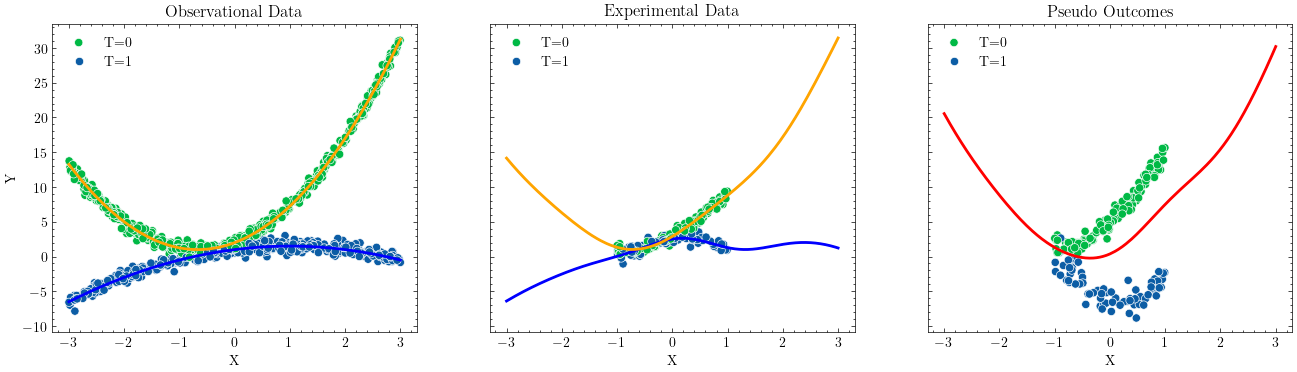

In [12]:
obs_exp_pseudo_plot(obs_data,exp_data,outcome_funcs_GP,T_prop=T_prop)

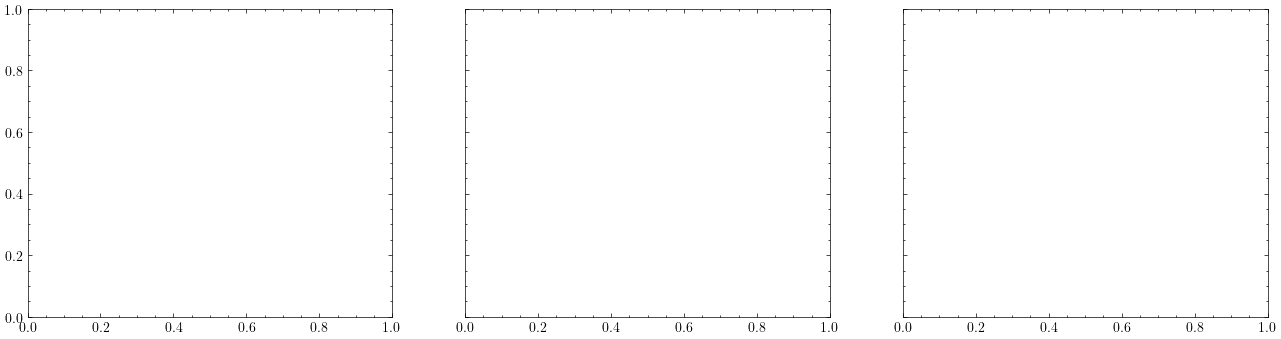

In [13]:
fig, axs= plt.subplots(ncols=3,sharex=True,figsize=(16,4),sharey=True)

In [14]:
pseudo_data = get_pseudo_outcome_data(exp_data,T_prop=T_prop)
pseudo_data_adjusted = adjust_data(pseudo_data,cfoundeded_CATE_func)

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = FixedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop,Train=False)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 1.569
Iter 2/50 - Loss: 1.556
Iter 3/50 - Loss: 1.545
Iter 4/50 - Loss: 1.538
Iter 5/50 - Loss: 1.533
Iter 6/50 - Loss: 1.530
Iter 7/50 - Loss: 1.528
Iter 8/50 - Loss: 1.528
Iter 9/50 - Loss: 1.528
Iter 10/50 - Loss: 1.530
Iter 11/50 - Loss: 1.531
Iter 12/50 - Loss: 1.532
Iter 13/50 - Loss: 1.533
Iter 14/50 - Loss: 1.533
Iter 15/50 - Loss: 1.532
Iter 16/50 - Loss: 1.531
Iter 17/50 - Loss: 1.530
Iter 18/50 - Loss: 1.529
Iter 19/50 - Loss: 1.528
Iter 20/50 - Loss: 1.528
Iter 21/50 - Loss: 1.527
Iter 22/50 - Loss: 1.527
Iter 23/50 - Loss: 1.527
Iter 24/50 - Loss: 1.527
Iter 25/50 - Loss: 1.527
Iter 26/50 - Loss: 1.528
Iter 27/50 - Loss: 1.528
Iter 28/50 - Loss: 1.528
Iter 29/50 - Loss: 1.528
Iter 30/50 - Loss: 1.528
Iter 31/50 - Loss: 1.528
Iter 32/50 - Loss: 1.528
Iter 33/50 - Loss: 1.527
Iter 34/50 - Loss: 1.527
Iter 35/50 - Loss: 1.527
Iter 36/50 - Loss: 1.527
Iter 37/50 - Loss: 1.527
Iter 38/50 - Loss: 1.527
Iter 39/50 - Loss: 1.527
Iter 40/50 - Loss: 1.527
Iter 41/5

KeyboardInterrupt: 

In [ ]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

In [ ]:
FIGSIZE = (16,4)

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_16774/697062000.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


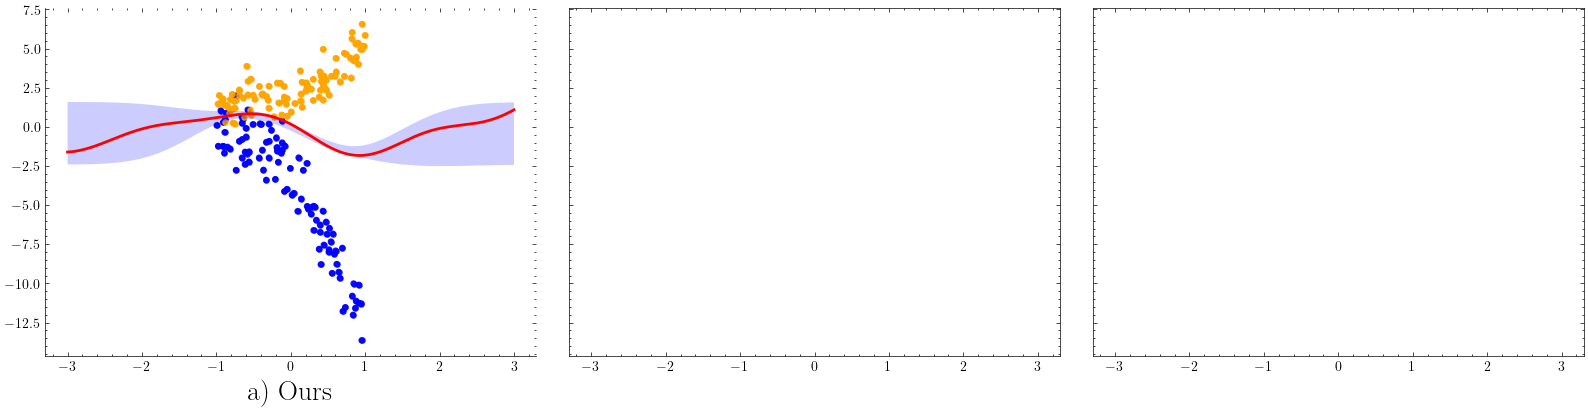

In [ ]:
fig, axs = plt.subplots(ncols=3,sharex=True,figsize=FIGSIZE,sharey=True)
fig.tight_layout()
axs[0].set_axisbelow(True)
axs[0].set_title("a) Ours",y=-0.15,fontsize = 20)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
colors = ["blue","orange"]

scatter = axs[0].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[0].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)


axs[0].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95\% CI')

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_StandardGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 13.893
Iter 2/50 - Loss: 13.012
Iter 3/50 - Loss: 12.215
Iter 4/50 - Loss: 11.495
Iter 5/50 - Loss: 10.846
Iter 6/50 - Loss: 10.261
Iter 7/50 - Loss: 9.734
Iter 8/50 - Loss: 9.260
Iter 9/50 - Loss: 8.834
Iter 10/50 - Loss: 8.451
Iter 11/50 - Loss: 8.106
Iter 12/50 - Loss: 7.795
Iter 13/50 - Loss: 7.514
Iter 14/50 - Loss: 7.261
Iter 15/50 - Loss: 7.031
Iter 16/50 - Loss: 6.822
Iter 17/50 - Loss: 6.632
Iter 18/50 - Loss: 6.458
Iter 19/50 - Loss: 6.300
Iter 20/50 - Loss: 6.155
Iter 21/50 - Loss: 6.021
Iter 22/50 - Loss: 5.899
Iter 23/50 - Loss: 5.785
Iter 24/50 - Loss: 5.681
Iter 25/50 - Loss: 5.584
Iter 26/50 - Loss: 5.494
Iter 27/50 - Loss: 5.410
Iter 28/50 - Loss: 5.333
Iter 29/50 - Loss: 5.260
Iter 30/50 - Loss: 5.192
Iter 31/50 - Loss: 5.129
Iter 32/50 - Loss: 5.069
Iter 33/50 - Loss: 5.012
Iter 34/50 - Loss: 4.959
Iter 35/50 - Loss: 4.908
Iter 36/50 - Loss: 4.859
Iter 37/50 - Loss: 4.811
Iter 38/50 - Loss: 4.765
Iter 39/50 - Loss: 4.721
Iter 40/50 - Loss: 4.678
Ite

KeyboardInterrupt: 

In [ ]:
model.covar_module.lengthscale

tensor([[0.0018]], grad_fn=<SoftplusBackward0>)

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 14.374874114990234
Parameter name: mean_module.raw_constant                   value = 0.3491515815258026
Parameter name: covar_module.raw_lengthscale               value = -6.315786361694336


In [ ]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

axs[1].set_axisbelow(True)
axs[1].set_title("b) Standard Pseudo Outcome GP",y=-0.15,fontsize = 20)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
colors = ["blue","orange"]

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[1].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)

axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

axs[1].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95% Credible Interval')


/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_16545/210411135.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = TrainedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 1.781
Iter 2/50 - Loss: 1.744
Iter 3/50 - Loss: 1.713
Iter 4/50 - Loss: 1.687
Iter 5/50 - Loss: 1.666
Iter 6/50 - Loss: 1.648
Iter 7/50 - Loss: 1.633
Iter 8/50 - Loss: 1.621
Iter 9/50 - Loss: 1.611
Iter 10/50 - Loss: 1.604
Iter 11/50 - Loss: 1.598
Iter 12/50 - Loss: 1.594
Iter 13/50 - Loss: 1.590
Iter 14/50 - Loss: 1.586
Iter 15/50 - Loss: 1.583
Iter 16/50 - Loss: 1.581
Iter 17/50 - Loss: 1.578
Iter 18/50 - Loss: 1.576
Iter 19/50 - Loss: 1.574
Iter 20/50 - Loss: 1.572
Iter 21/50 - Loss: 1.569
Iter 22/50 - Loss: 1.567
Iter 23/50 - Loss: 1.566
Iter 24/50 - Loss: 1.564
Iter 25/50 - Loss: 1.562
Iter 26/50 - Loss: 1.561
Iter 27/50 - Loss: 1.560
Iter 28/50 - Loss: 1.559
Iter 29/50 - Loss: 1.558
Iter 30/50 - Loss: 1.557
Iter 31/50 - Loss: 1.557
Iter 32/50 - Loss: 1.556
Iter 33/50 - Loss: 1.556
Iter 34/50 - Loss: 1.556
Iter 35/50 - Loss: 1.556
Iter 36/50 - Loss: 1.556
Iter 37/50 - Loss: 1.556
Iter 38/50 - Loss: 1.556
Iter 39/50 - Loss: 1.556
Iter 40/50 - Loss: 1.556
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

axs[2].set_axisbelow(True)
axs[2].set_title("c) LCM Multi-Task GP",y=-0.15,fontsize = 20)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
colors = ["blue","orange"]

axs[2].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")

axs[2].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_16545/3977321430.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")


In [ ]:
fig.suptitle("Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors",fontsize = 20,y=1.05)

Text(0.5, 1.05, 'Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors')

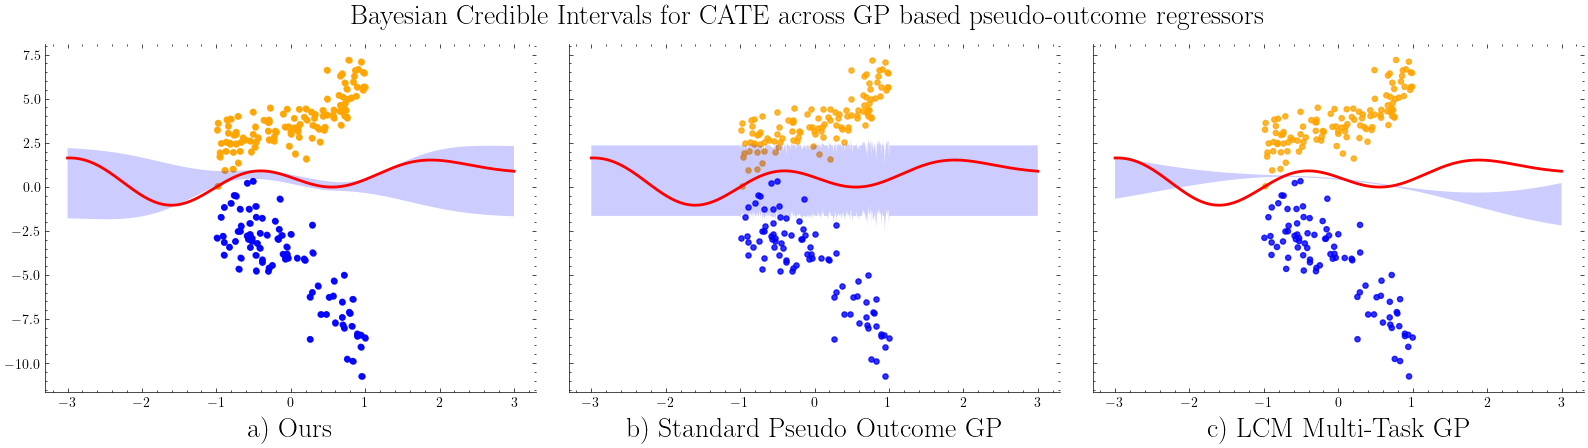

In [ ]:
fig

In [ ]:
CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

In [ ]:
(region_upper - region_lower).mean()

tensor(0.7405, grad_fn=<MeanBackward0>)

In [ ]:
def compare_cate_to_guas(CATE,CATE_pred_guas):
    CATE_MSE = torch.mean((CATE - CATE_pred_guas.mean)**2)
    region_lower,region_upper = custom_confidence_region(CATE_pred_guas)
    CATE_coverage = (torch.logical_and((region_lower < Y_true_CATE_GAP),(region_upper > Y_true_CATE_GAP))).float().mean()
    average_interval_width = (region_upper - region_lower).mean()
    return CATE_MSE,CATE_coverage,average_interval_width

In [ ]:
handles, labels = axs[0].get_legend_handles_labels()
labels[3],labels[1] = labels[1],labels[3]
handles[1],handles[3] = handles[3],handles[1]
# legend1 = axs[0].legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# reverse the order
legend2 =axs[0].legend(handles, labels,ncols=2,loc="upper left")
# axs[0].legend()

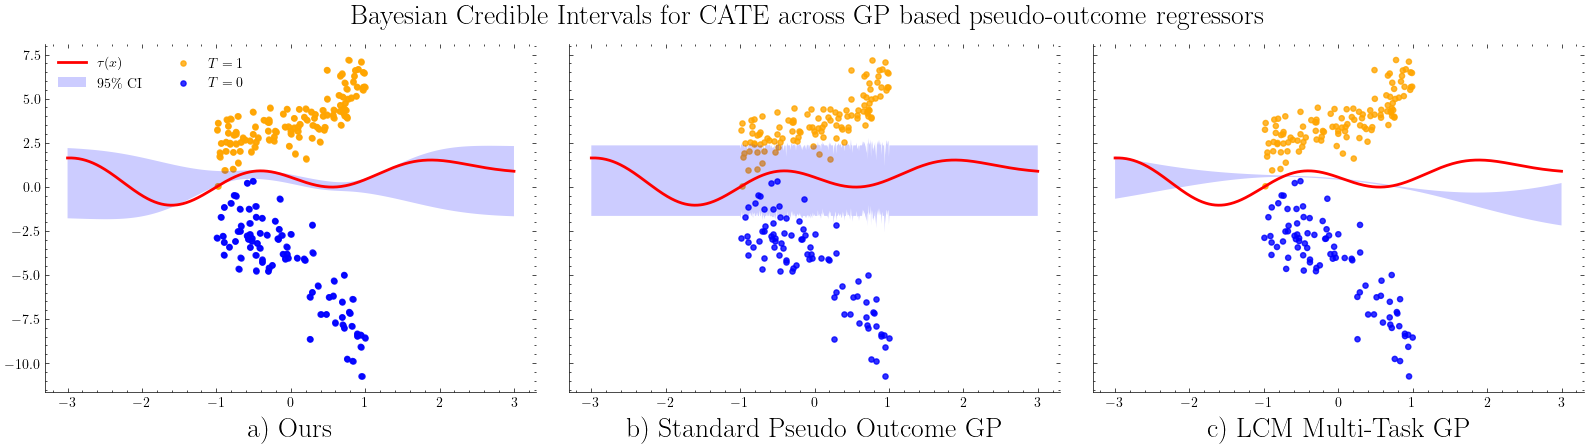

In [ ]:
fig

In [ ]:
d = 5
X_d = torch.rand(n_samples_obs,d)

In [ ]:
get_gp_samples(X_d,dimx=d,train_data=None,likelihood=None)

tensor([-4.4210e-01,  5.5868e-02,  1.3391e+00, -9.9657e-01,  1.9053e+00,
        -1.1937e-01,  9.4403e-03,  8.2439e-01, -8.0360e-03, -2.0113e-01,
        -4.7786e-01,  1.1332e-01, -3.0826e-01, -1.3590e+00, -1.6480e-01,
        -1.0075e+00,  1.0964e+00, -5.1837e-01, -6.9203e-01, -3.2256e-01,
         4.7422e-02,  2.9448e-01, -1.8378e-01, -4.8495e-01,  1.6572e-01,
         6.9331e-01, -8.1222e-01,  3.2211e-01, -9.3125e-01, -8.2796e-01,
        -8.5533e-01,  1.3130e-01, -2.8135e-02, -9.1120e-01,  1.3741e+00,
        -1.0232e+00,  4.8301e-01, -1.2379e+00,  1.2659e+00, -2.2083e-01,
        -1.0355e+00, -2.7993e-01,  7.7283e-01,  9.6076e-01,  1.2646e+00,
        -3.4177e-01, -7.0142e-01, -1.0267e+00,  9.5008e-01,  5.7096e-01,
         4.0393e-01, -1.6595e-01,  6.6234e-01, -1.4818e-01, -9.7352e-01,
        -1.7522e-01,  6.4852e-01,  3.2623e-01, -3.2886e-01, -1.1255e-01,
        -1.1718e+00,  8.8953e-01, -1.1348e+00, -4.5629e-01, -1.2056e+00,
        -7.3690e-01,  2.4854e-01, -1.3437e+00,  1.2

In [16]:
X_range = (-1,1)
d=5
N_eval_points=100
train_data=None
likelihood=None
scale=1

In [17]:
start_range = [X_range[0]]*d
end_range = [X_range[1]]*d
X_eval = multidim_linspace(start_range, end_range, N_eval_points)

: 

In [ ]:
Y_eval = get_gp_samples(X_eval.reshape(d,-1).T,dimx=d,kernel="RFF",num_samples_RFF=20)

tensor([-0.6815, -0.6497, -0.6178,  ..., -0.3470, -0.3634, -0.3772])

In [ ]:
X_eval = torch.linspace(X_range[0],X_range[1],steps=N_eval_points)
Y_eval = get_gp_samples(X_eval,train_data=train_data,likelihood=likelihood)
def GP(X):
    a = ((N_eval_points-1)*(X-X_range[0])/(X_range[1]-X_range[0])).int()
    return scale*Y_eval[a]

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [ ]:
kern = gpytorch.kernels.RFFKernel(num_samples=100,num_dims=dimx)